In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cartpole_lib_python import *
import odrive

In [2]:
init_odrive()

axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
odrive initialized


In [3]:
odrv = get_odrive()
odrive.utils.dump_errors(odrv)

axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none


In [36]:
print(get_state())

[0.014374262845909577, 1.5600584612796973, -3.686290856902879e-05, 0.0001402155992713981]


1.560058461279697

In [38]:
control_frequency = 60 # Hz
control_period = 1/control_frequency
T = 15 # runtime, seconds
N = int(T*control_frequency)
print("N: ", N)

xg = np.array([0, 1.560058461279697, 0, 0])

# 60 hz
k_matrix = np.array([-3.43659, -34.39494, -5.15817, -8.42840]) * 0.2
A = np.array([[1.00000, -0.00096, 0.01667, -0.00001/2],
            [0.00000, 1.00499, 0.00000, 0.01669/2],
            [0.00000, -0.11483, 1.00000, -0.00096/2],
            [0.00000, 0.59871, 0.00000, 1.00499/2]])
B = np.array([[0.00035],
            [-0.00076],
            [0.04260],
            [-0.09164]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

meas_noise_cov = np.diag([.1,.1]) # most recent
process_noise_cov = np.diag([1,1,50,50]) # position, angle, linear velocity, angular velocity

nx = process_noise_cov.shape[0]
def kf_update(x_meas, x_pred_prev, est_cov_prev):
    Kn = est_cov_prev@H.T @ np.linalg.inv(H@est_cov_prev@H.T + meas_noise_cov)
    x = x_pred_prev + Kn @ (x_meas - H@x_pred_prev)
    est_cov = (np.eye(nx) - Kn@H) @ est_cov_prev @ (np.eye(nx) - Kn@H).T + Kn@meas_noise_cov@Kn.T
    return x, est_cov

def kf_predict(state, control, est_cov):
    x_pred = A@state + B@control
    est_cov_pred = A@est_cov@A.T + process_noise_cov
    return x_pred, est_cov_pred

# Initialize Kalman filter variables
# First state estimate
meas = get_measurement() - xg[:2]
x = np.array([meas[0], meas[1], 0, 0])
x_pred_prev = x
# Estimation covariance
est_cov = np.eye(4)*20
est_cov_prev = est_cov

xs = np.zeros(np.append(x.shape, N))
measurements = np.zeros((2,N))
controls = np.zeros(N)
control_clamp = .3

# for i in range(N):
i = 0
while True:
    time_start = time.perf_counter()
    
    measurement = get_measurement() - xg[:2]
    if i > 0:
        x, est_cov = kf_update(measurement, x_pred_prev, est_cov_prev)
    
    xs[:,i] = x
    measurements[:,i] = measurement
    control = -k_matrix @ x
    control = min(control_clamp, max(-control_clamp, control))
    
    x_pred_prev, est_cov_prev = kf_predict(x, [control], est_cov)
    
    command_linear_torque(-control)
    # command_linear_torque(0)
    controls[i] = control
    
    if measurement[1] < -.5 or measurement[1] > .5:
        break
    
    i += 1
    busy_sleep(control_period, time_start, get_now=time.perf_counter)


command_linear_torque(0)

N:  900


In [11]:
for i in range(3):
    start = time.perf_counter()
    command_linear_torque(.1)
    busy_sleep(.1, start, get_now=time.perf_counter)
    command_linear_torque(-.1)
    busy_sleep(.2, start, get_now=time.perf_counter)
command_linear_torque(0)

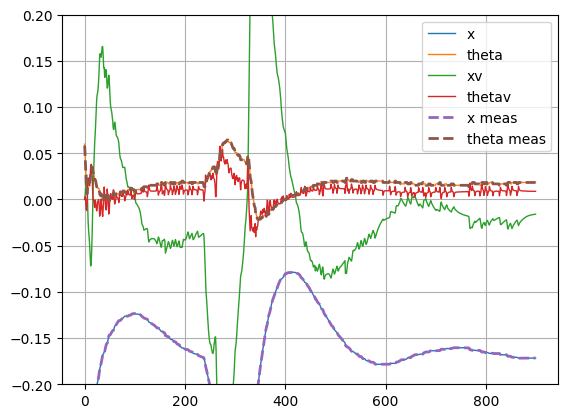

In [152]:
plt.plot(xs.T, '-', linewidth=1)
plt.plot(measurements.T, '--', linewidth=2)
plt.ylim([-.2,.2])
# plt.legend(['x', 'theta', 'xv', 'thetav'])
plt.legend(['x', 'theta', 'xv', 'thetav', 'x meas', 'theta meas'])
plt.grid()
plt.show()

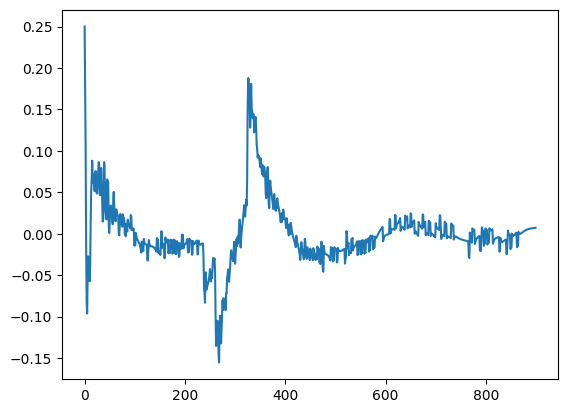

In [155]:
plt.plot(controls)